In [ ]:
!pip install pytorch-lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 10.1 MB/s eta 0:00:00


In [ ]:
# imports
import os

import torch
from pytorch_lightning import LightningModule, Trainer, LightningDataModule
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

In [ ]:
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
AVAIL_GPUS

1

In [ ]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(LightningDataModule):
    """
    Custom Dataset Class
    """
    def __init__(self, dataset, transforms=None):
        """Initialize Dataset
        Args:
            dataset (Dataset): Pytorch Dataset instance
            transforms (Transform.Compose, optional): Tranform function instance. Defaults to None.
        """
        self.transforms = transforms
        self.dataset = dataset
    def __len__(self):
        """Get dataset length
        Returns:
            int: Length of dataset
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """Get an item form dataset
        Args:
            idx (int): id of item in dataset
        Returns:
            (tensor, int): Return tensor of transformer image, label
        """
        # Read Image and Label
        image, label = self.dataset[idx]

        image = np.array(image)
        # Apply Transforms
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]
        return (image, label)

In [ ]:
train_transform= A.Compose([
        A.Normalize(mean=(0.49139968, 0.48215827 ,0.44653124), std=(0.24703233,0.24348505,0.26158768), always_apply = True),
        A.PadIfNeeded(min_height = 40, min_width = 40, always_apply =True),
        A.RandomCrop(32,32, p = 0.5,always_apply = True),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.49139968, 0.48215827 ,0.44653124), mask_fill_value = None),
        ToTensorV2(),
    ])

test_transform = A.Compose([
        A.Normalize(mean=(0.49139968, 0.48215827 ,0.44653124), std=(0.24703233,0.24348505,0.26158768)),
        ToTensorV2(),
    ])

In [ ]:
train_loader = DataLoader(
                        MyDataset(CIFAR10(PATH_DATASETS, train=True,
                                    download=True), transforms=train_transform),
                        batch_size=BATCH_SIZE, shuffle=True,num_workers=os.cpu_count())

test_loader = DataLoader(
                        MyDataset(CIFAR10(PATH_DATASETS, train=False,
                                    download=True), transforms=test_transform),
                        batch_size=BATCH_SIZE, shuffle=False,num_workers=os.cpu_count())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class CIFAR10DataModule(LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        # self.data_dir = data_dir
        # self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

    def prepare_data(self):
        pass
        # download
        # CIFAR10(self.data_dir, train=True, download=True)
        # CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        pass
        # Assign train/val datasets for use in dataloaders
        # if stage == "fit":
        #     cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
        #     self.cifar_train, self.cifar_val = random_split(cifar_full, [55000, 5000])

        # # Assign test dataset for use in dataloader(s)
        # if stage == "test":
        #     self.cifar_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

        # if stage == "predict":
        #     self.cifar_predict = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return test_loader

    def test_dataloader(self):
        return test_loader

    def predict_dataloader(self):
        return test_loader

In [ ]:
dm = CIFAR10DataModule()

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, stride=1, padding=1, downsample = None):
        super(ResBlock, self).__init__()
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride, padding = padding),
                                    nn.BatchNorm2d(out_channels),
                                    # nn.ReLU(inplace=False)
                                    )
        self.block2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size, stride = stride, padding = padding),
                                    nn.BatchNorm2d(out_channels))

        self.downsample = downsample
        self.relu = nn.ReLU(inplace=False)
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.block1(x)
        out = self.block2(out)
        if self.downsample:
            residual = self.downsample(x)
        out+=residual
        out = self.relu(out)
        return out

In [ ]:
class LightningDavidNet(LightningModule):

    def __init__(self,data_dir=PATH_DATASETS, hidden_size=16, learning_rate=2e-4,kernel_size=3, stride=1, padding=1, downsample = None):
        super().__init__()
        self.learning_rate =learning_rate
        self.data_dir = data_dir
        self.hidden_size = hidden_size

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.prep = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace=False))
        self.l1X = nn.Sequential(nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                                nn.MaxPool2d(kernel_size = 2),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace=False))
        self.r1 = ResBlock(128, 128,kernel_size=3, stride=1, padding=1, downsample = None)
        self.l2X = nn.Sequential(nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
                                nn.MaxPool2d(kernel_size = 2),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace=False))
        self.l3X = nn.Sequential(nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
                                nn.MaxPool2d(kernel_size = 2),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace=False))
        self.r2 = ResBlock(512, 512,kernel_size=3, stride=1, padding=1, downsample = None)
        self.maxPool = nn.MaxPool2d(kernel_size = 4)
        self.fc1 = nn.Linear(512,10)

        self.accuracy = Accuracy(task = "multiclass",num_classes = self.num_classes)

    def forward(self, x):
        x = self.prep(x)
        x = self.l1X(x)
        residual = x
        x = self.r1(x)
        x= residual+ x
        x = self.l2X(x)
        x = self.l3X(x)
        residual = x
        x = self.r2(x)
        x=residual+x
        x = self.maxPool(x)
        # # x = self.avgpool(x)
        x = x.view(-1,512)
        x = self.fc1(x)
        x = F.log_softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x,y = batch
        loss = F.cross_entropy(self(x), y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.03, weight_decay=1e-4)
        steps_per_epoch = len(train_loader)
        scheduler_dict = {
            "scheduler": torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

        # lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, step_size=1)
        # return [optimizer], [lr_scheduler]
        # return optimizer

    def validation_step(self, batch, batch_idx):
        x,y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits,dim = 1)
        self.accuracy(preds,y)
        self.log("val_loss",loss, prog_bar = True)
        self.log("val_arr",self.accuracy,prog_bar = True)

    def test_step(self,batch,batch_idx):
        return self.validation_step(batch,batch_idx)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x,y = batch
        output = self(x)
        return x,y,output.argmax(dim=1),output



### Training

In [ ]:
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar

In [ ]:
Lighting_davidnet = LightningDavidNet()

In [ ]:
# initialize the trainer
trainer = Trainer(
    max_epochs = 24,
    logger = loggers.TensorBoardLogger("logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(Lighting_davidnet,datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | prep     | Sequential         | 1.9 K 
1 | l1X      | Sequential         | 74.1 K
2 | r1       | ResBlock           | 295 K 
3 | l2X      | Sequential         | 295 K 
4 | l3X      | Sequential         | 1.2 M 
5 | r2       | ResBlock           | 4.7 M 
6 | maxPool  | MaxPool2d          | 0     
7 | fc1      | Linear             | 5.1 K 
8 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
6.6 M     Trainab

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


In [ ]:
trainer.test(Lighting_davidnet,datamodule=dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_arr          │     0.772599995136261     │
│         val_loss          │    0.6515687704086304     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.6515687704086304, 'val_arr': 0.772599995136261}]

In [ ]:
trainer.save_checkpoint("model.ckpt")

### Inference

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
test_model = LightningDavidNet().load_from_checkpoint('model.ckpt')

In [ ]:
# dir(dm)

In [ ]:
trainer = Trainer()
temp = trainer.predict(test_model, dm.test_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
len(temp[0][3])

256

In [ ]:
incorrect = []
for d, t, p, o in zip(temp[0][0], temp[0][1], temp[0][2], temp[0][3]):
  if p.eq(t.view_as(p)).item() == False:
      incorrect.append([d.cpu(), t.cpu(), p.cpu(), o[p.item()].cpu()])

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)

In [ ]:
len(incorrect)

61

In [81]:
def plot_incorrect_predictions(predictions, class_map, count=30):
    """Plot Incorrect predictions

    Args:
        predictions (list): List of all incorrect predictions
        class_map (dict): Lable mapping
        count (int, optional): Number of samples to print, multiple of 5. Defaults to 10.
    """
    print(f'Total Incorrect Predictions {len(predictions)}')

    # if not count % 5 == 0:
    #     print("Count should be multiple of 10")
    #     return

    classes = list(class_map.values())
    counter = 1
    fig = plt.figure(figsize=(10, 5))
    for i, (d, t, p, o) in enumerate(predictions):
        # ax = fig.add_subplot()
        title = f'{classes[t.item()]}/{classes[p.item()]}'
        # ax.set_title(title)
        plt.title(title)
        temp_img = plt.imshow(inv_normalize(d.cpu()).numpy().transpose(1, 2, 0))
        # plt.imshow(temp_img)
        # imgplot = plt.imshow(temp_img)
        # print(type(temp_img))
        plt.savefig(f'/content/misclassified/{counter}.jpg')
        counter +=1
        if counter == count:
            break

In [82]:
class_map = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}

Total Incorrect Predictions 61


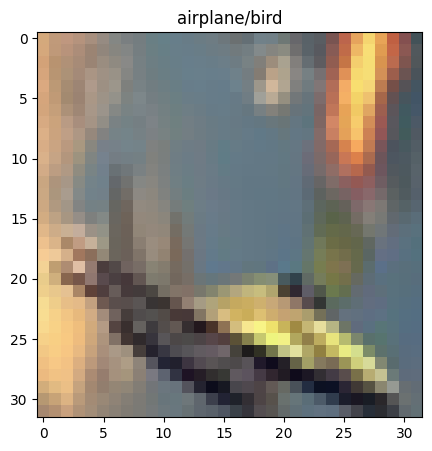

In [83]:
plot_incorrect_predictions(incorrect, class_map, count=30)

In [85]:
!zip -r images.zip '/content/misclassified'

updating: content/misclassified/ (stored 0%)
  adding: content/misclassified/3.jpg (deflated 26%)
  adding: content/misclassified/14.jpg (deflated 26%)
  adding: content/misclassified/1.jpg (deflated 28%)
  adding: content/misclassified/24.jpg (deflated 26%)
  adding: content/misclassified/19.jpg (deflated 24%)
  adding: content/misclassified/28.jpg (deflated 36%)
  adding: content/misclassified/10.jpg (deflated 25%)
  adding: content/misclassified/21.jpg (deflated 27%)
  adding: content/misclassified/27.jpg (deflated 26%)
  adding: content/misclassified/5.jpg (deflated 25%)
  adding: content/misclassified/9.jpg (deflated 25%)
  adding: content/misclassified/17.jpg (deflated 25%)
  adding: content/misclassified/7.jpg (deflated 26%)
  adding: content/misclassified/8.jpg (deflated 25%)
  adding: content/misclassified/25.jpg (deflated 27%)
  adding: content/misclassified/26.jpg (deflated 27%)
  adding: content/misclassified/11.jpg (deflated 26%)
  adding: content/misclassified/12.jpg (def